In [1]:
import os
import sys
import skimage.io
from mrcnn import model as modellib
from mrcnn import utils
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt

In [2]:
ROOT_DIR = "/Users/fatimanevrekar/Desktop/Plant_Health_Detection/Plant_Health_MaskRCNN"
print("ROOT_DIR:",ROOT_DIR)

ROOT_DIR: /Users/fatimanevrekar/Desktop/Plant_Health_Detection/Plant_Health_MaskRCNN


In [3]:
# CustomConfig and CustomDataset are defined in custom.py in the ROOT_DIR
sys.path.append(ROOT_DIR)  # To find local version of the library
from custom import CustomConfig, CustomDataset

In [4]:
# Define the configuration for inference
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.999  # increase to be more selective; reduce to allow more detections
    DETECTION_NMS_THRESHOLD = 0.3  # decrease to be more aggressive in suppressing close detections

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.999
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE       

In [11]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
print("MODEL_DIR:",MODEL_DIR)

MODEL_DIR: /Users/fatimanevrekar/Desktop/Plant_Health_Detection/Plant_Health_MaskRCNN/logs


In [12]:
# Create the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)

In [13]:

# Define your model directory and model weights file
MODEL_DIR = os.path.join(ROOT_DIR, "logs")  # Set this to the directory where your logs and model weights are stored
MODEL_WEIGHTS_PATH = os.path.join(MODEL_DIR, "object20231118T2114/mask_rcnn_object_0038.h5")  # Replace with your actual weights filename

# Create the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)

# Load weights trained on your dataset
model.load_weights(MODEL_WEIGHTS_PATH, by_name=True)



2023-11-19 22:48:19.665286: W tensorflow/c/c_api.cc:304] Operation '{name:'bn3d_branch2c_1/gamma/Assign' id:8487 op device:{requested: '', assigned: ''} def:{{{node bn3d_branch2c_1/gamma/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bn3d_branch2c_1/gamma, bn3d_branch2c_1/gamma/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Re-starting from epoch 38


In [14]:
# Define class names for visualization purposes
class_names = ['BG', 'Potato_Early_Blight', 'Potato_Healthy', 'Potato_Late_Blight', 'Tomato_Healthy', 'Tomato_Leaf_Mold', 'Tomato_Leaf_Spot']

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


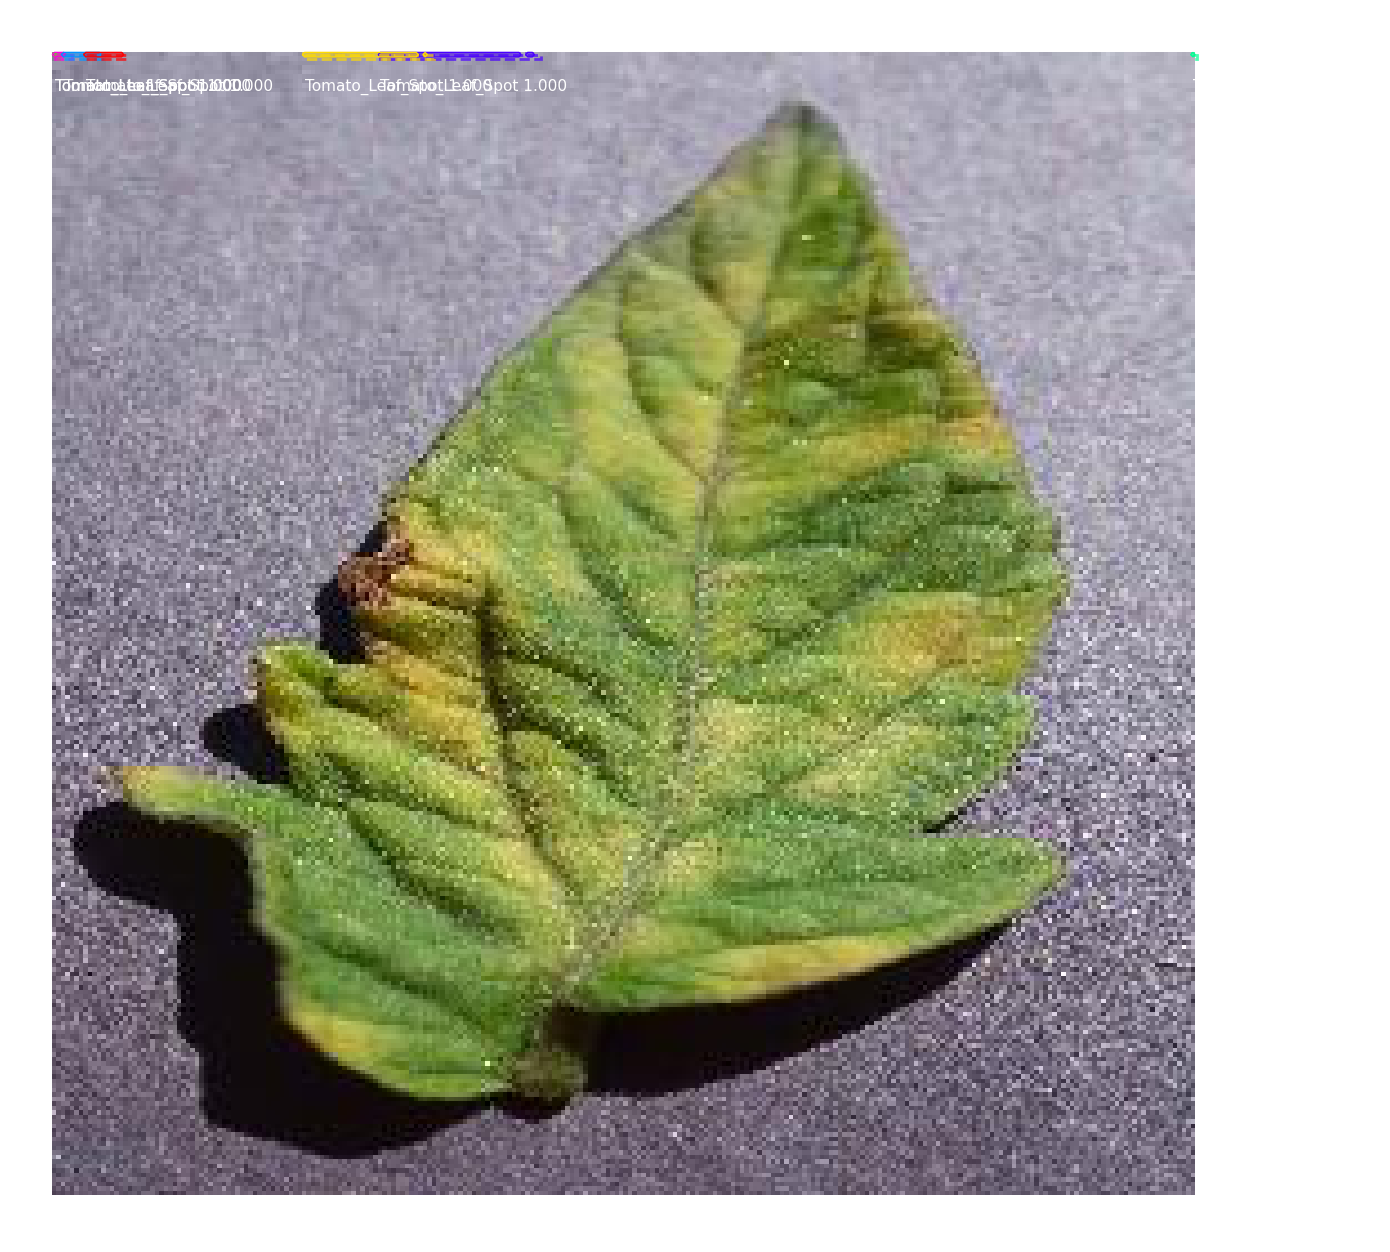

In [18]:
def apply_nms(objects, scores, nms_threshold=0.3):
    # Apply non-maximum suppression to avoid multiple detections of the same object
    keep_indices = utils.non_max_suppression(objects, scores, nms_threshold)
    return keep_indices

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in all visualizations."""
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

def filter_detections_by_score(r, threshold=0.999):
    """Filter detections by score"""
    keep_idxs = r['scores'] > threshold
    if not any(keep_idxs):
        return r  # return original if no detections above threshold
    r_filtered = {k: v[keep_idxs] for k, v in r.items() if k != 'masks'}
    r_filtered['masks'] = r['masks'][:, :, keep_idxs]
    return r_filtered
def detect_and_visualize(model, image_path, nms_threshold=0.3):
    # Define your class names here
    class_names = ['BG', 'Potato_Early_Blight', 'Potato_Healthy', 'Potato_Late_Blight',
                   'Tomato_Healthy', 'Tomato_Leaf_Mold', 'Tomato_Leaf_Spot']

    # Load the image
    image = skimage.io.imread(image_path)

    # Detect objects in the image
    results = model.detect([image], verbose=1)
    r = results[0]

    # Apply NMS
    keep_indices = apply_nms(r['rois'], r['scores'], nms_threshold=nms_threshold)
    
    # Filter results after NMS
    filtered_rois = r['rois'][keep_indices]
    filtered_class_ids = r['class_ids'][keep_indices]
    filtered_scores = r['scores'][keep_indices]
    filtered_masks = r['masks'][:, :, keep_indices]

    # Visualize the results
    display_instances(image, filtered_rois, filtered_masks, filtered_class_ids, 
                      class_names, filtered_scores)

image_path = '/Users/fatimanevrekar/Desktop/Plant_Health_Detection/Plant_Health_MaskRCNN/tomato_leaf_mold(569).JPG'
detect_and_visualize(model, image_path)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

2023-11-20 01:32:07.265014: W tensorflow/c/c_api.cc:304] Operation '{name:'bn4p_branch2a_2/moving_mean/Assign' id:21749 op device:{requested: '', assigned: ''} def:{{{node bn4p_branch2a_2/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bn4p_branch2a_2/moving_mean, bn4p_branch2a_2/moving_mean/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Re-starting from epoch 38
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


2023-11-20 01:32:09.208067: W tensorflow/c/c_api.cc:304] Operation '{name:'bn4s_branch2a_4/moving_variance/Assign' id:40324 op device:{requested: '', assigned: ''} def:{{{node bn4s_branch2a_4/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bn4s_branch2a_4/moving_variance, bn4s_branch2a_4/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 01:32:10.844078: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -48 } dim { size: -308 } dim { size: -309 } dim { size: 2

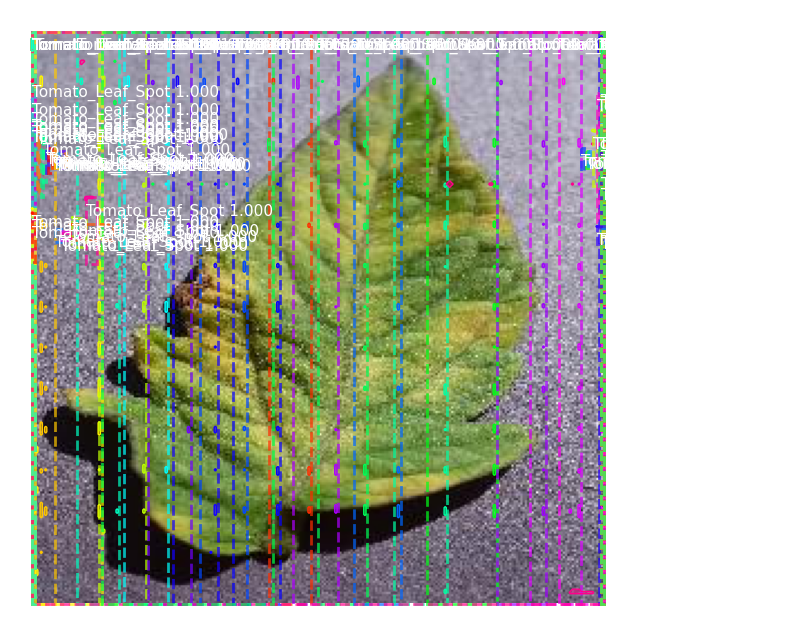

In [19]:
import os
import sys
import skimage.io
import matplotlib.pyplot as plt
from mrcnn import model as modellib
from mrcnn import utils
from mrcnn.visualize import display_instances

# Root directory of the project
ROOT_DIR = "/Users/fatimanevrekar/Desktop/Plant_Health_Detection/Plant_Health_MaskRCNN"
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Please check your path.'

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from custom import CustomConfig, CustomDataset  # Replace 'custom' with the actual name of the python file where your CustomConfig and CustomDataset are defined.

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
MODEL_WEIGHTS_PATH = os.path.join(MODEL_DIR, "object20231118T2114/mask_rcnn_object_0038.h5")  # Replace with your model weights file name
assert os.path.exists(MODEL_WEIGHTS_PATH), 'MODEL_WEIGHTS_PATH does not exist. Please check your path.'

# Define the configuration for inference
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.9  # Adjust based on your model's performance

config = InferenceConfig()
config.display()

# Create the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)

# Load weights
print("Loading weights from ", MODEL_WEIGHTS_PATH)
model.load_weights(MODEL_WEIGHTS_PATH, by_name=True)

# Define class names for visualization purposes
class_names = ['BG', 'Potato_Early_Blight', 'Potato_Healthy', 'Potato_Late_Blight', 'Tomato_Healthy', 'Tomato_Leaf_Mold', 'Tomato_Leaf_Spot']

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in all visualizations."""
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

def detect_and_visualize(model, image_path):
    image = skimage.io.imread(image_path)
    
    # Run detection
    results = model.detect([image], verbose=1)
    r = results[0]
    
    # Visualize results
    ax = get_ax(1)
    display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'], ax=ax)
    plt.show()

# Replace with the path to your image
image_path = os.path.join(ROOT_DIR, "tomato_leaf_mold(569).JPG")
assert os.path.exists(image_path), 'Image path does not exist. Please check your path.'

detect_and_visualize(model, image_path)


In [21]:
import os
import sys
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn.config import Config
from mrcnn.visualize import display_instances

# Assume ROOT_DIR is the directory where your code and model are located.
# Root directory of the project
ROOT_DIR = "/Users/fatimanevrekar/Desktop/Plant_Health_Detection/Plant_Health_MaskRCNN"
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Please check your path.'

# Custom configuration
class CustomConfig(Config):
    NAME = "Object"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 6  # background + number of classes
    # Other configurations specific to your project

# Inference configuration
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.9  # or the value you used during training

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
TRAINED_MODEL_PATH = os.path.join(MODEL_DIR, "tomato_leaf_mold(569).JPG")

# Create model object in inference mode.
config = InferenceConfig()
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load trained weights
print("Loading weights from ", TRAINED_MODEL_PATH)
model.load_weights(TRAINED_MODEL_PATH, by_name=True)

# Class names (replace these with your actual class names)
class_names = ['BG', 'class1', 'class2', 'class3']  # Add all classes

# Load a random image
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, np.random.choice(file_names)))

# Run object detection
results = model.detect([image], verbose=1)
r = results[0]

# Visualize results
display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])


Loading weights from  /Users/fatimanevrekar/Desktop/Plant_Health_Detection/Plant_Health_MaskRCNN/logs/tomato_leaf_mold(569).JPG


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/Users/fatimanevrekar/Desktop/Plant_Health_Detection/Plant_Health_MaskRCNN/logs/tomato_leaf_mold(569).JPG', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)